In [1]:
%matplotlib inline

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import io
import codecs
import re
import folium
from dateutil import parser
from janome.tokenizer import Tokenizer
from wordcloud import WordCloud
from collections import Counter, defaultdict
from pykakasi import kakasi
from googletrans import Translator
sns.set(color_codes=True)

# Load data

In [2]:
today = datetime.date.today() - datetime.timedelta(1)
until = str(today)
print(until)

2018-06-04


In [3]:
# whether Iida=0 or Yawatahama=1
#flag = 0
flag = 1

In [4]:
if flag == 0:
    words = ['飯田市', '飯田線秘境駅', '飯田水引', '下栗の里', '遠山郷', 'りんご並木', 'しらびそ高原', '野底山森林公園']
else:
    words = ['八幡浜', 'マーマレード大会', 'どーや市場', 'どーや食堂', '日土小学校', 'アゴラマルシェ', 'もっきんろーど', '諏訪崎', 
         '平家谷', 'みなと湯', 'ゆめみかん', 'はまぽん']

In [5]:
Kakasi = kakasi()

Kakasi.setMode('H', 'a')
Kakasi.setMode('K', 'a')
Kakasi.setMode('J', 'a')

conv = Kakasi.getConverter()
YH_df = pd.DataFrame()
for word in words:
    df = pd.read_csv('tweet/' + until + '/' + conv.do(word) + '_' + until + '.csv', sep = '\t',encoding='utf-16')
    YH_df = pd.concat([YH_df, df])


# EDA

In [6]:
print("num of tweet: ", YH_df.shape[0])

num of tweet:  1216


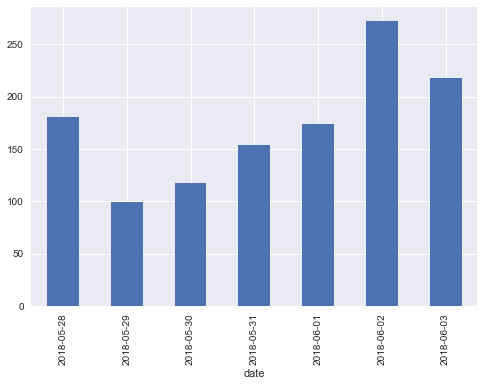

In [7]:
YH_df["date"] = pd.to_datetime(YH_df["created_at"], errors='coerce')
YH_df.groupby(YH_df["date"].dt.date).date.count().plot(kind="bar")

# WordCloud (only noun)

In [8]:
YH_df = YH_df[YH_df['text'].notnull()]

In [9]:
#半角英字
alphaReg = re.compile(r'^[a-zA-Z]+$')
def isalpha(s):
    return alphaReg.match(s) is not None

In [10]:
# janome 形態素分解
def janome_analysis(sentences, output, POS='名詞'):
    t = Tokenizer()
    words_count = defaultdict(int)
    words = []
    for sentence in sentences:
        tokens = t.tokenize(sentence)
        for token in tokens:
            # 品詞を取り出し
            partOfSpeech1 = token.part_of_speech.split(',')[0]
            partOfSpeech2 = token.part_of_speech.split(',')[1]
            
            if output == "normal":
                if partOfSpeech2 == '固有名詞' or partOfSpeech1 == '形容詞':
#                     if (token.base_form != ':' and 
#                         token.base_form != '@' and
#                         token.base_form != 'RT'):
    #                    token.base_form != '#' and 
    #                     token.base_form != '-' and
    #                     token.base_form != '/' and
    #                     token.base_form != '(' and
    #                     token.base_form != ')' and
    #                     token.base_form != '.'):
                    if isalpha(token.base_form) == False: 
                        words_count[token.base_form] += 1
                        words.append(token.base_form)
            elif output == "cloud":
                if partOfSpeech1 == POS:

                    words_count[token.base_form] += 1
                    words.append(token.base_form)
    return words_count, words

In [11]:
texts = YH_df['text'].str.replace('http\S+', '', case=False)
words_count, words = janome_analysis(texts, "cloud", "名詞")
text = ' '.join(words)

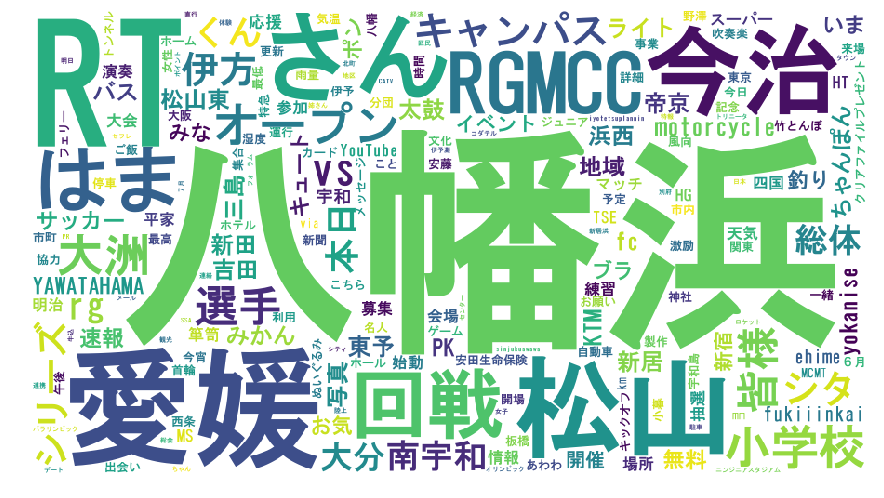

In [12]:
fpath = "C:\Windows\Fonts\HGRGE.TTC"
#word cloud
wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, collocations=False).generate(text)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("sample.png")
plt.show()

In [13]:
words_count2, words2 = janome_analysis(texts, "cloud", "形容詞")
text2 = ' '.join(words2)

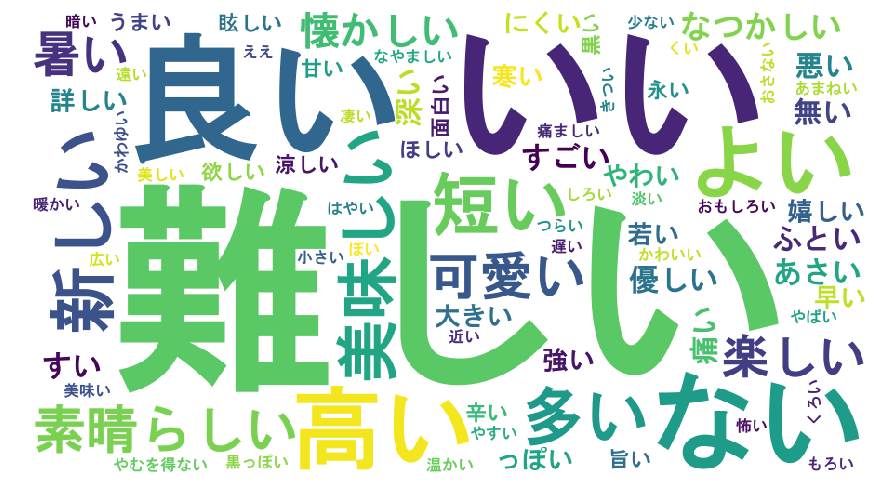

In [14]:
wordcloud2 = WordCloud(background_color="white", font_path=fpath, width=900, height=500, collocations=False).generate(text2)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [15]:
words_count3, words3 = janome_analysis(texts, "cloud", "動詞")
text3 = ' '.join(words3)

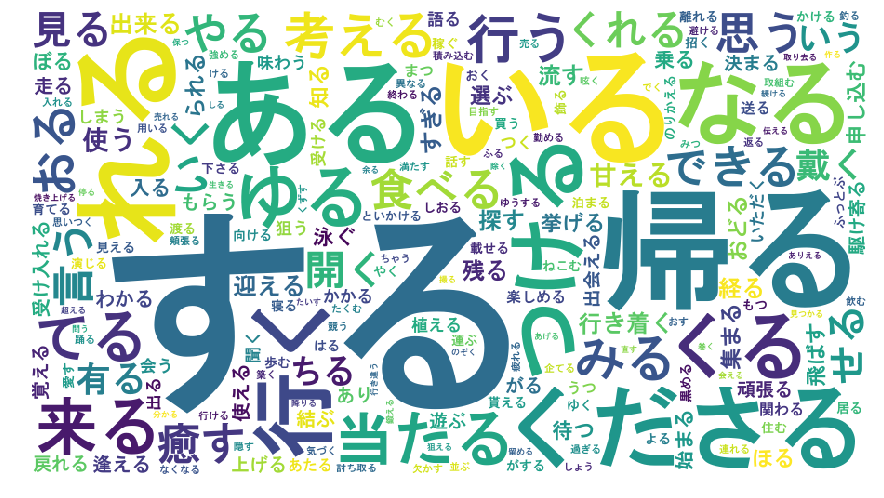

In [16]:
wordcloud3 = WordCloud(background_color="white", font_path=fpath, width=900, height=500, collocations=False).generate(text3)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud3)
plt.axis("off")
plt.show()

# English version

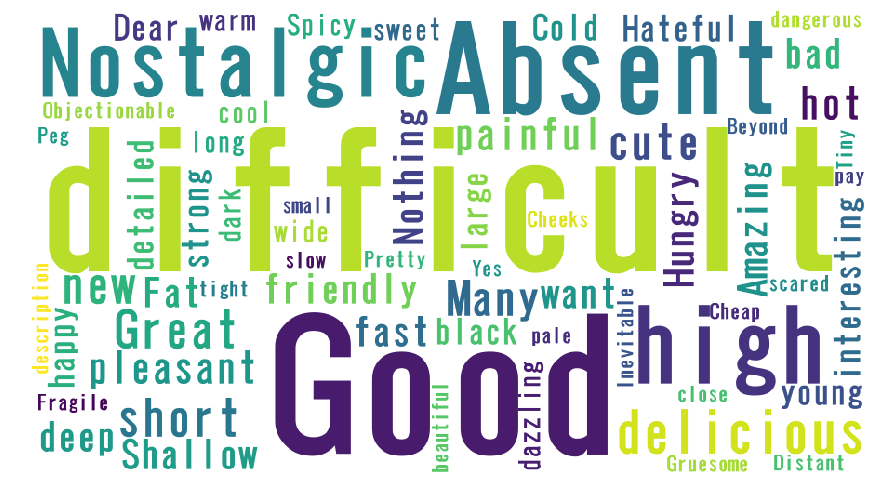

In [17]:
translator = Translator()
a = translator.translate(words2)
en_list = [word.text for word in a]
en_text = ' '.join(en_list)

wordcloud4 = WordCloud(background_color="white", font_path=fpath, width=900, height=500, collocations=False).generate(en_text)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud4)
plt.axis("off")
plt.show()

In [1]:
translator = Translator()
a = translator.translate(words3)
en_list = [word.text for word in a]
en_text = ' '.join(en_list)

wordcloud4 = WordCloud(background_color="white", font_path=fpath, width=900, height=500, collocations=False).generate(en_text)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud4)
plt.axis("off")
plt.show()

NameError: name 'Translator' is not defined

# Explore frequent word (proper nouns and adjective)

In [18]:
YH_wo_rt = YH_df[YH_df['RT']==False]
YH_wo_rt = YH_wo_rt['text'].str.replace('http\S+', '', case=False)

In [19]:
words_count5, words5 = janome_analysis(YH_wo_rt, "normal")

In [20]:
Counter(words3).most_common()[:5]

[('する', 562), ('帰る', 128), ('いる', 111), ('ある', 91), ('く', 91)]

# Sentiment analysis

In [21]:
class CorpusElement:
    def __init__(self, text='', tokens=[], pn_scores=[]):
        self.text = text # テキスト本文
        self.tokens = tokens # 構文木解析されたトークンのリスト
        self.pn_scores = pn_scores # 感情極性値(後述)


# CorpusElementのリスト
naive_corpus = []

naive_tokenizer = Tokenizer()

for text in YH_wo_rt:
    tokens = naive_tokenizer.tokenize(text)
    element = CorpusElement(text, tokens)
    naive_corpus.append(element)

# 最初の1文章の形態素解析結果を表示
# for token in naive_corpus[0].tokens:
#     print(token)

In [22]:
# pn_ja.dicファイルから、単語をキー、極性値を値とする辞書を得る
def load_pn_dict():
    dic = {}
    
    with codecs.open('./pn_ja.dic', 'r', 'shift_jis') as f:
        lines = f.readlines()
        
        for line in lines:
            # 各行は"良い:よい:形容詞:0.999995"
            columns = line.split(':')
            dic[columns[0]] = float(columns[3])
            
    return dic

In [23]:
# トークンリストから極性値リストを得る
def get_pn_scores(tokens, pn_dic):
    scores = []
    
    for surface in [t.surface for t in tokens if t.part_of_speech.split(',')[0] in ['動詞','名詞', '形容詞', '副詞']]:
        if surface in pn_dic:
            scores.append(pn_dic[surface])
    
    if len(scores) == 0:
        scores.append(0)
    
    return scores

In [24]:
# 感情極性対応表のロード
pn_dic = load_pn_dict()

# 各文章の極性値リストを得る
for element in naive_corpus:
    element.pn_scores = get_pn_scores(element.tokens, pn_dic)

In [25]:
# 平均値が最も高い5件を表示
print('------------Show the 5 most postiive tweets------------------')
for element in sorted(naive_corpus, key=lambda e: sum(e.pn_scores)/len(e.pn_scores), reverse=True)[:5]:
    print('Score: {:.3f}'.format(sum(element.pn_scores)/len(element.pn_scores)))
    print('Text: {}'.format(io.StringIO(element.text).readline()))
    print('')


# 平均値が最も低い5件を表示
print('------------Show the 5 most negative tweets------------------')
for element in sorted(naive_corpus, key=lambda e: sum(e.pn_scores)/len(e.pn_scores))[:5]:
    print('Average: {:.3f}'.format(sum(element.pn_scores)/len(element.pn_scores)))
    print('Title: {}'.format(io.StringIO(element.text).readline()))
    print('')

#     for surface in [t.surface for t in element.tokens if t.part_of_speech.split(',')[0] in ['動詞','名詞', '形容詞', '副詞']]:
#         if surface in pn_dic:
#             print(surface)
    
#     print(element.pn_scores)
#     print('')

------------Show the 5 most postiive tweets------------------
Score: 0.990
Text: 八幡浜で生クリームいちご大福なるものを買ってみた。 

Score: 0.373
Text: アメブロを更新しました。 『愛媛・八幡浜からお届け！』 #ライム #製法


Score: 0.278
Text: 今日気付いたんだけど八幡浜は配布状況をまとめてて面白い。

Score: 0.274
Text: 【KoumuWIN!更新】 八幡浜市 

Score: 0.053
Text: 八幡浜に名鉄バスがいるって結構感動モノなんだが。 

------------Show the 5 most negative tweets------------------
Average: -0.990
Title: 八幡浜はやばい

Average: -0.979
Title: 八幡浜のみかん山から。 

Average: -0.958
Title: 八幡浜なう！仕事で・・・


Average: -0.932
Title: 八幡浜にも黒湯…？

Average: -0.863
Title: 平家谷なんかよう行くわ～




# Check the most retweeted tweet

In [26]:
for i in range(5):
    print('num of retweet: ', YH_df['text'].value_counts().tolist()[i])
    print(YH_df['text'].value_counts().index.tolist()[i])
    print('')
    print('------------------------------------------------------------------')

num of retweet:  60
RT @fukiiinkai: 皆様！本日はオープンキャンパス、
誠に有難うごさいまシタ！
皆様のキラキラとしたお顔が、
いとキュートでシタ！

家に帰るまでがオープンキャンパスでス！お気をつけてお帰りください！！ 
ポンっ！！！！

はまのどうさん！はまのどうさん！
写真難し…

------------------------------------------------------------------
num of retweet:  39
RT @yokanise12: 愛媛県総体サッカー
【速報】
◎1回戦
三島1-0南宇和
松山東1-0大洲
松山聖陵3-3東予
（PK5-4）

◎2回戦
松山工1-0今治西
済美5-0八幡浜工
新田5-0新居浜西
今治工4-0吉田
松山北2-0帝京第五
今治東5-1三島
宇和…

------------------------------------------------------------------
num of retweet:  34
RT @ehime_fc: 6/10(日)大分戦HGイベント

★MS 明治安田生命保険
・ライト！くん来場
・クリアファイルプレゼント
・ライト！くんぬいぐるみなどが当たるHT抽選会！
★MCMT 八幡浜市・伊方町
・八幡浜竹とんぼ名人
・伊方堂々太鼓ジュニア太鼓演奏
★ゆる…

------------------------------------------------------------------
num of retweet:  34
RT @rg_motorcycle: RGMCC 八幡浜シリーズ始動！
#八幡浜市 
#愛媛県
#ちゃんぽん 
#釣り
#街ブラ 
#KTM
#RGMCC  
#YAWATAHAMA https://t.co/qx6ktoRImi

------------------------------------------------------------------
num of retweet:  20
RT @iyotetsuplannin: 愛媛FCを無料バスで応援に行こう！
ホームゲーム開催日に今治、西条、大洲からニンジニアスタジアムまで無料直行バスが運行中♪
本日は八幡浜

# Plot the map

In [27]:
if flag == 0:
    Yawatahama_map = folium.Map(location=[35.5150, 137.8214], zoom_start=12)
else:
    Yawatahama_map = folium.Map(location=[33.4629, 132.4233], zoom_start=12)

In [28]:
YH_map_df = YH_df.dropna()

for i, r in YH_map_df.iterrows():
#   folium.Marker(location=[r['latitude'], r['longitude']], popup=r['text']).add_to(Yawatahama_map)
    folium.Marker(location=[r['latitude'], r['longitude']]).add_to(Yawatahama_map)
    
Yawatahama_map